In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
from custom_causal_inference import CustomCausalInference
import utils
import forward_models_causal_inference
import matplotlib.pyplot as plt
import pickle

In [2]:
%reload_ext autoreload

In [6]:
D = 250  # grid dimension 
NUM_SIM = 10000  # number of simulations
angle_gam_data_path = './base_bayesian_contour_1_circular_gam.pkl'
unif_fn_data_path='./uniform_model_base_inv_kappa_free.pkl'
p_commons = np.linspace(0, 1, num=20)
t_index = 0

causal_inference_estimator = forward_models_causal_inference.CausalEstimator(
    model=CustomCausalInference(decision_rule='mean'),
    angle_gam_data_path=angle_gam_data_path,
    unif_fn_data_path=unif_fn_data_path)
unif_map = causal_inference_estimator.unif_map

In [7]:
grid_sz = 100
optimal_kappa_pairs_filepath = f'./learned_data/optimal_kappa_pairs_{grid_sz}_t{t_index}.pkl'
min_error_for_idx_pc_filepath = f'./learned_data/min_error_for_idx_pc_{grid_sz}_t{t_index}.pkl'
min_error_for_idx_filepath = f'./learned_data/min_error_for_idx_{grid_sz}_t{t_index}.pkl'
s_ns_filepath = f'./learned_data/selected_s_n_{grid_sz}_t{t_index}.npy'
ts_filepath = f'./learned_data/selected_t_{grid_sz}_t{t_index}.npy'
r_ns_filepath = f'./learned_data/selected_r_n_{grid_sz}_t{t_index}.npy'

In [8]:
with open(optimal_kappa_pairs_filepath, 'rb') as f:
    optimal_kappa_pairs = pickle.load(f)
with open(min_error_for_idx_pc_filepath, 'rb') as f:
    min_error_for_idx_pc = pickle.load(f)
with open(min_error_for_idx_filepath, 'rb') as f:
    min_error_for_idx = pickle.load(f)
s_ns = np.load(s_ns_filepath)
ts = np.load(ts_filepath)
r_ns = np.load(r_ns_filepath)

In [ ]:
grid_dim = int(np.sqrt(s_ns.shape[0]))
grid_dim

In [ ]:
plt.scatter(s_ns, r_ns, label = 'r_n as fn of s_n')
#plt.scatter(ts, r_ns, label='r_n as fn of t')
plt.plot(s_ns, s_ns, label='s_n', c='r')
plt.legend()
plt.savefig(f'./figs/sn_vs_rn_{grid_sz}_t{t_index}.png')
plt.clf()
plt.scatter(np.linspace(np.min(s_ns), np.max(s_ns), num=grid_dim), s_ns[:grid_dim])
plt.title('Selected s_n as a function of uniform stimuli in angle space')
plt.savefig(f'./figs/selected_sn_{grid_sz}_t{t_index}.png')
plt.clf()

In [16]:
err_mat = np.zeros_like(s_ns)
optimal_kappa_pairs_arr = np.zeros((*s_ns.shape, 2)) # 2 kappa values
optimal_pc = np.zeros_like(s_ns)
err_threshold = np.deg2rad(5)

test_fwd_sim = True
fwd_errors = np.zeros_like(s_ns)
for key in min_error_for_idx_pc:
    if min_error_for_idx_pc[key] == min_error_for_idx[key[0]]:
        # key[0] is the index of means s.t. causal inference is performed on (s_n[key[0]], t[key[0]])
        # key[1] is the optimal p_common for the pair
        optimal_pc[key[0]] = key[1]
        err_mat[int(key[0])] = min_error_for_idx[key[0]]
        optimal_kappa_pairs_arr[int(key[0]), :] = np.array(optimal_kappa_pairs[key]).reshape(2,)
        if min_error_for_idx_pc[key] >= err_threshold:
            print(f'{key[0]}: t, s_n, r_n = {np.round(s_ns[key[0]], 3), np.round(ts[key[0]], 3), np.round(r_ns[key[0]], 4)}', 
                f'd/pi={np.round(utils.circular_dist(s_ns[key[0]], ts[key[0]]) / np.pi, 4)}', 
                f'min_err={min_error_for_idx_pc[key]}',  
                f'p_c={np.round(key[1], 3)}', 
                f'optimal_kappa={optimal_kappa_pairs[key]}')
        if test_fwd_sim:
            mean_sn_ests = []
            for _ in range(30):
                usn, ut = unif_map.angle_space_to_unif_space([s_ns[key[0]]]), unif_map.angle_space_to_unif_space([ts[key[0]]])
                t_samples, s_n_samples = causal_inference_estimator.get_vm_samples(
                            num_sim=10000,
                            mu_t=ut,
                            mu_s_n=usn,
                            kappa1=optimal_kappa_pairs[key][0],
                            kappa2=optimal_kappa_pairs[key][1])
                _, _, _, mean_sn_est = causal_inference_estimator.forward(t_samples=t_samples,
                    s_n_samples=s_n_samples, 
                                                                        kappa1=optimal_kappa_pairs[key][0], 
                                                                        kappa2=optimal_kappa_pairs[key][1], 
                                                                        p_common=key[1])
                mean_sn_ests.append(mean_sn_est[0,0])
                assert mean_sn_est.shape == (1, 1)
            del t_samples, s_n_samples
            fwd_errors[key[0]] = sum(map(lambda x: utils.circular_dist(x, r_ns[key[0]]), mean_sn_ests)) / len(mean_sn_ests)
            if (np.rad2deg(utils.circular_dist(max(mean_sn_ests), min(mean_sn_ests))) > 2):
                print('Max dif across 10 estimates for index', key, np.rad2deg(utils.circular_dist(max(mean_sn_ests), min(mean_sn_ests))))
            if abs(fwd_errors[key[0]] - min_error_for_idx_pc[key]) > err_threshold:
                print(f'Error forward vs fits {key[0]}', fwd_errors[key[0]], np.rad2deg(abs(fwd_errors[key[0]] - min_error_for_idx_pc[key])), np.rad2deg(utils.circular_dist(max(mean_sn_ests), min(mean_sn_ests))))


Max dif across 10 estimates for index (25, 0.2631578947368421) 2.1818740650768684
31: t, s_n, r_n = (-1.274, -0.694, -0.5054) d/pi=0.1847 min_err=0.17728925846396626 p_c=0.895 optimal_kappa=(array([200.]), array([1.1]))
32: t, s_n, r_n = (-0.971, -0.694, -0.3778) d/pi=0.0884 min_err=0.2908016210927098 p_c=0.842 optimal_kappa=(array([200.]), array([1.1]))
33: t, s_n, r_n = (-0.694, -0.694, -0.3649) d/pi=0.0 min_err=0.29428533852956784 p_c=0.842 optimal_kappa=(array([200.]), array([1.1]))
34: t, s_n, r_n = (-0.517, -0.694, -0.3803) d/pi=0.0562 min_err=0.14691863891036938 p_c=0.0 optimal_kappa=(array([1.74668135]), array([300.]))
41: t, s_n, r_n = (-1.274, -0.517, -0.2964) d/pi=0.241 min_err=0.23048828551166256 p_c=0.947 optimal_kappa=(array([200.]), array([1.1]))
42: t, s_n, r_n = (-0.971, -0.517, -0.1256) d/pi=0.1446 min_err=0.3991226504054093 p_c=0.947 optimal_kappa=(array([200.]), array([1.1]))
43: t, s_n, r_n = (-0.694, -0.517, -0.173) d/pi=0.0562 min_err=0.3412230631212796 p_c=0.895

In [19]:
print(f'Indices where optimal kappa1 > kappa2: {np.sum(optimal_kappa_pairs_arr[:, 0] >= optimal_kappa_pairs_arr[:, 1])} {optimal_kappa_pairs_arr[:, 0] >= optimal_kappa_pairs_arr[:, 1]}')

Indices where optimal kappa1 > kappa2: 89 [False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False False False  True  True  True  True  True  True False False  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False]


In [20]:
print(f'Kappa values where optimal kappa1 > kappa2: {optimal_kappa_pairs_arr[optimal_kappa_pairs_arr[:, 0] >= optimal_kappa_pairs_arr[:, 1]]}')

Kappa values where optimal kappa1 > kappa2: [[  9.30796486   6.4650238 ]
 [  9.30796486   2.66674449]
 [ 16.25804865   4.81253485]
 [114.50285407   4.81253485]
 [ 28.3976304    3.58242946]
 [200.           1.98511269]
 [  9.30796486   1.47770902]
 [  3.05089575   1.98511269]
 [  9.30796486   1.47770902]
 [ 49.60161148   1.1       ]
 [ 49.60161148   1.1       ]
 [ 86.63820982   1.98511269]
 [ 12.30159931   1.1       ]
 [ 12.30159931   1.1       ]
 [ 86.63820982   2.66674449]
 [ 86.63820982   1.47770902]
 [ 49.60161148   1.47770902]
 [ 49.60161148  15.67324238]
 [ 12.30159931   1.98511269]
 [200.           1.1       ]
 [114.50285407   1.1       ]
 [114.50285407   1.1       ]
 [ 16.25804865  11.66709164]
 [114.50285407  28.28468397]
 [ 65.55451795   1.1       ]
 [ 49.60161148   4.81253485]
 [200.           8.68493093]
 [  3.05089575   1.98511269]
 [  4.03212706   3.58242946]
 [ 86.63820982   2.66674449]
 [200.           1.1       ]
 [200.           1.1       ]
 [200.           1.1       ]

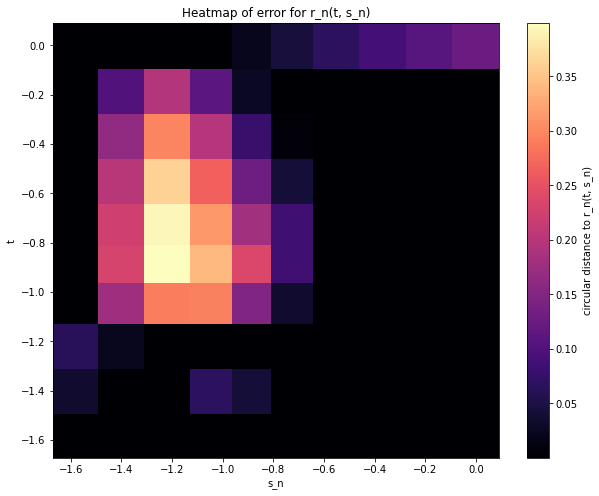

In [ ]:
usns = unif_map.angle_space_to_unif_space(s_ns)
uts = unif_map.angle_space_to_unif_space(ts)
plt.figure(figsize=(10, 8))
plt.pcolormesh(usns.reshape((grid_dim, grid_dim)), uts.reshape((grid_dim, grid_dim)), 
               err_mat.reshape((grid_dim, grid_dim)), shading='auto', cmap='magma')
plt.colorbar(label='circular distance to r_n(t, s_n)')
plt.xlabel('s_n')
plt.ylabel('t')
plt.title('Heatmap of error for r_n(t, s_n)')
plt.savefig(f'./figs/error_heatmap_uspace_{grid_sz}_t{t_index}.png')
plt.clf()

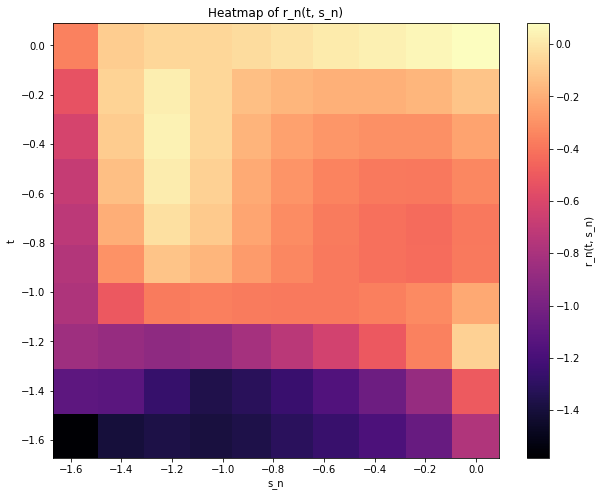

In [ ]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(usns.reshape((grid_dim, grid_dim)), 
               uts.reshape((grid_dim, grid_dim)), 
               r_ns.reshape((grid_dim, grid_dim)), shading='auto', cmap='magma')
plt.colorbar(label='r_n(t, s_n)')
plt.xlabel('s_n')
plt.ylabel('t')
plt.title('Heatmap of r_n(t, s_n)')
plt.savefig(f'./figs/r_n_axis_u_space_{grid_sz}_t{t_index}.png')
plt.clf()

In [24]:
optimal_kappa_ratio = optimal_kappa_pairs_arr[:, 1] / optimal_kappa_pairs_arr[:, 0]
plt.figure(figsize=(10, 8))
plt.pcolormesh(usns.reshape((grid_dim, grid_dim)), uts.reshape((grid_dim, grid_dim)), 
               optimal_kappa_pairs_arr[:, 1].reshape((grid_dim, grid_dim)), shading='auto', cmap='RdBu')
plt.colorbar(label='optimal_kappa_ratio(t, s_n)')
plt.xlabel('us_n')
plt.ylabel('ut')
plt.title('Heatmap of $\kappa_{s_n}(t, s_n)}$')
plt.savefig(f'./figs/optimal_kappa_ratio_{grid_sz}_t{t_index}.png')
plt.clf()

for k_index in [0, 1]:
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(usns.reshape((grid_dim, grid_dim)), uts.reshape((grid_dim, grid_dim)), 
                optimal_kappa_pairs_arr[:, k_index].reshape((grid_dim, grid_dim)), shading='auto', cmap='RdBu')
    plt.colorbar(label='optimal_kappa_ratio(t, s_n)')
    plt.xlabel('us_n')
    plt.ylabel('ut')
    if k_index == 0:
        # plot latex doesn't support variables :(
        plt.title(f'Heatmap of $\kappa_1(t, s_n)$')
    else:
        plt.title(f'Heatmap of $\kappa_2(t, s_n)$')
    plt.savefig(f'./figs/kappa{k_index+1}_{grid_sz}_t{t_index}.png')
    plt.clf()

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(usns.reshape((grid_dim, grid_dim)), uts.reshape((grid_dim, grid_dim)), 
               optimal_pc.reshape((grid_dim, grid_dim)), shading='auto', cmap='RdBu')
plt.colorbar(label='p_common(ut, us_n)')
plt.xlabel('s_n')
plt.ylabel('t')
plt.title('Heatmap of optimal p_common(ut, us_n)')
plt.savefig(f'./figs/p_common_{grid_sz}_t{t_index}.png')
plt.clf()

## Looking at optimal $\kappa$ pairs

In [ ]:
import pickle

grid_sz = 81
with open(f'./learned_data/task_metadata_{grid_sz}_t{t_index}.pkl', 'rb') as f:
    tasks_metadata = pickle.load(f)
num_tasks = len(tasks_metadata)
print(f'Number of tasks: {num_tasks}')
errors_dicts = {}
err_for_idx = {}
nums_bad = 0
max_error = 0
high_err_idx = []
for task_idx in range(num_tasks):
    try:
        with open(f'./learned_data/optimal_kappa_errors/errors_dict_{task_idx}_{grid_sz}_t{t_index}.pkl', 'rb') as f:
            errors_dicts[task_idx] = pickle.load(f)
            mean_idx = tasks_metadata[task_idx]['mean_indices'][0]
            min_error_across_pc = min([errors_dicts[task_idx][p_c]['errors'].min() for p_c in errors_dicts[task_idx].keys()])
            if mean_idx not in err_for_idx:
                err_for_idx[mean_idx] = min_error_across_pc
            else:   
                err_for_idx[mean_idx] = min(err_for_idx[mean_idx], min_error_across_pc)
    except:
        nums_bad += 1
        print(f'Error for task {task_idx}')
print(f'Number of bad tasks: {nums_bad}')
for mean_idx in err_for_idx:
    if err_for_idx[mean_idx] > .1:
        high_err_idx.append(mean_idx)
    max_error = max(err_for_idx[mean_idx], max_error)
print(f'Max error: {max_error}')
print(high_err_idx, '\n', list(zip(zip(s_ns[high_err_idx], ts[high_err_idx]), r_ns[high_err_idx])))

Number of tasks: 81
Number of bad tasks: 0
Max error: 0.3916801571684698
[28, 29, 30, 37, 38, 39, 40, 46, 47, 48, 55, 56, 57, 64, 65, 79, 80] 
 [((-0.1892525694933611, -0.9714965233992534), -0.35595155), ((-0.06308418983112052, -0.9714965233992534), -0.079912424), ((-1.5771047457780087, -0.6939260881423239), -0.78163743), ((-0.26495359729070556, -0.6939260881423239), -0.36372972), ((-0.1892525694933611, -0.6939260881423239), -0.32800508), ((-0.06308418983112052, -0.6939260881423239), -0.22025418), ((-1.5771047457780087, -0.5172903566151867), -0.7605517), ((-0.34065462508805, -0.5172903566151867), -0.3824799), ((-0.26495359729070556, -0.5172903566151867), -0.41731572), ((-0.1892525694933611, -0.5172903566151867), -0.43105817), ((-0.41635565288539444, -0.41635565288539444), -0.31982255), ((-0.34065462508805, -0.41635565288539444), -0.37721944), ((-0.26495359729070556, -0.41635565288539444), -0.4193461), ((-0.5172903566151867, -0.34065462508805), -0.21205354), ((-0.41635565288539444, -0.3